### Introduction: 

Welcome to Day 2 of your C3 AI V8 Workshop. You have now created your own App, integrated data, and engineered Features and stored Features in the Feature Store

### Assignment: 
During the model development phase of the workshop, you will develop machine learning models for predictive maintenance for Wind Turbines. In particular, you will learn about:
- Building, training, and operationalize machine learning models using `MlPipeline`

This exercise assumes working knowledge of the Python libraries pandas and scikit-learn, and that you have attended introductory sessions or have read through the tutorial notebooks for `Data`, `Feature.Set` and `MlPipeline`.

### Before You Start: 

In this notebook you will find...
* Cells with a "blue" banner and the keyword "Exercise", these provide specific instructions on what needs to be done. 
* Blank cells with "TODO" comments. Your goal is to fill in these cells with the necessary code. Try doing this on your own, but if you need help, you can ask a C3 AI team member or refer to the _Solutions_ notebook located in the same folder
* You can press TAB for auto-completion, and SHIFT+TAB to reveal both the signature of a function and additional documentation. You can also directly access documentation for any C3 Type by using the `help()` function.
* If you get stuck, you can take a look at the tutorial notebooks for hints or reach out to one of the C3 AI team member. 

# Generate Demo Data

These notebooks depend on data being loaded into the WindTurbine entity types. This can be done
via Data Integration or by running this notebook to generate sample data in place.

In [ ]:
c3.WindTurbineDataGenerator.cleanDemoData()

In [ ]:
c3.WindTurbineDataGenerator.createDemoData(numberOfAssets=6,
                   assetPrefix="TURBINE",
                   manufacturerOptions=["Siemens", "GE"],
                   powerOptions=[150, 200],
                   locationOptions=["USA", "FRANCE"])

## Evaluate Feature Data for Training

In [1]:
X_feature_set = c3.Feature.Set.forId("WindTurbine#windTurbineFeatures_ml")
y_feature_set = c3.Feature.Set.forId("WindTurbine#labelFeatureSet")

In [2]:
# make sure the feature sets have been materialized
X_feature_set.materialize(sync=True)
y_feature_set.materialize(sync=True)

In [3]:
X_features = c3.WindTurbine.evalFeatureSetBatch(featureSet = X_feature_set, 
                                                filter = "location == 'FRANCE'", start='2022-01-02', end='2022-05-20')

y_features = c3.WindTurbine.evalFeatureSetBatch(featureSet = y_feature_set, 
                                                filter = "location == 'FRANCE'", start='2022-01-02', end='2022-05-20')

In [4]:
X_features.head()

subject  ... generatorRotationSpeed_rolling_std_ml
0  demo_TURBINE-3  ...                            319.544841
1  demo_TURBINE-3  ...                            309.486003
2  demo_TURBINE-3  ...                            297.961775
3  demo_TURBINE-3  ...                            284.794322
4  demo_TURBINE-3  ...                            266.496375

[5 rows x 17 columns]

In [5]:
y_features.head()

subject           timestamp  willFailNextDayFeature
0  demo_TURBINE-3 2022-01-02 00:00:00                     0.0
1  demo_TURBINE-3 2022-01-02 01:00:00                     0.0
2  demo_TURBINE-3 2022-01-02 02:00:00                     0.0
3  demo_TURBINE-3 2022-01-02 03:00:00                     0.0
4  demo_TURBINE-3 2022-01-02 04:00:00                     0.0

## Train / Test Split

Before training our model, we split our data into training and testing data sets based on a split date. 

In [6]:
from datetime import datetime
split_date = datetime(2022, 4, 30)
X_train = X_features.loc[X_features["timestamp"] <= split_date]
X_test = X_features.loc[X_features["timestamp"] > split_date]
y_train = y_features.loc[y_features["timestamp"] <= split_date]
y_test = y_features.loc[y_features["timestamp"] > split_date]

## Create scikit-learn `MlPipe`s

Next, we import the scikit-learn estimators that we will use in our training pipeline.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

These native estimators are instantiated and then converted to `MlPipe`s using `mla.convert()`. 

<div class="alert-info">
    <b>Exercise</b>: 

We have imported the sklearn estimators that we want to use in our Pipeline `RandomForestClassifier` and `StandardScaler`. We need to convert the native sklearn objects to two `MlPipe`s so that we can use them in our `MlPipeline`
    <br/>
    <div><i>Hint</i>: The `MlPipeline.Authoring` module has a `convert` function to convert native estimates to `MlPipe`. Look up the function using `help(MlPipeline.Authoring)`
    </div>
    <br/>
    <div>
    <i>Hint</i>: The function `MlPipeline.Authoring.convert` takes two arguments a `model` and an **optional** `spec`. In this case, `SklearnLikeConvertSpec` gives you options for how to convert the model to an `MlPipe`. For example, for `RandomForestClassifier` we can set the `MlPipe` to use the `predict` function when processing instead of the `predict_proba` function.
    </div>
</div>

In [8]:
# TODO: Create two MlPipe(s) for StandardScaler and RandomForestClassifier

mla = c3.MlPipeline.Authoring

ss = StandardScaler()
ss_pipe = mla.convert(ss)

clf = LogisticRegression()
clf_pipe = mla.convert(model = clf, spec=c3.SklearnLikeConvertSpec(processFunc='predict'))

Default process function for StandardScaler set to transform()
Default process function for LogisticRegression set to predict()


Let's define two `MlScoringMetric`s to score the model - precision and recall.

In [9]:
precision_pipe = c3.MlPrecisionMetric()
recall_pipe = c3.MlRecallMetric()

## Construct the DAG `MlPipeline`

We can combine the pipes defined above into an `MlPipeline`. This is a DAG representation of `MlPipe`s that can be directly deployed to production.

<div class="alert-info">
    <b>Exercise</b>: 

Let's use the MlPipes defined above - `ss_pipe`, `clf_pipe`, `precision_pipe`, `recall_pipe` to construct an `MlPipeline` that takes two inputs, and returns and `out` of predictions, and scores of `precision` and `recall`. The `MlPipeline` should use the `StandardScaler` to scale the `X_input`
    <br/>
    <div><i>Hint</i>: To author an `MlPipeline` starting from native models:
<ol>
<li>Instantiate native models</li>
<li>Convert native models to c3 pipes (i.e., `MlAtomicPipe`)</li>
<li>Compose `MlPipe`s and variables `MlVar` (i.e., playing the role of placeholders for input/output to `MlPipe`) to create `MlPipeline`s.</li>
</ol>
    </div>

</div>

Your resulting Pipeline should look like this:


In [10]:
# TODO: Author a MLPipeline
# Create Variables to hold input. 
X_input, y_input = mla.var(), mla.var()

# Create Pipe dependencies. Each line takes the form of: output = pipe(inputs, ...)
ss_out = ss_pipe(X_input)
y_output = clf_pipe(ss_out, y_input) ## the clf_pipe takes two positional arguments: x and y
recall = recall_pipe(y_input , y_output) ## the MlScoringMetric takes two positional arguments: targetOutput, modelOutput
precision = precision_pipe(y_input, y_output)

# Create a pipeline. Pass a map as input/output.
pipeline = mla.pipeline(
    name='workshop-dag',
    x={'features': X_input},
    y={'failureLabel': y_input}, 
    out={'riskScore': y_output},
    scores={'precision':precision, 'recall':recall} ##scores returns a dictionary where keys are strings, and values are outputs of the pipeline
)

## Visualize the DAG `MlPipeline`

In [11]:
pipeline.visualize()

## Train the `MlPipeline`

In [12]:
pipeline_trained = pipeline.train(
    x={'features': X_train}, 
    y={'failureLabel': y_train}
).result()

## Predict Using the Trained `MlPipeline`

<div class="alert-info">
    <b>Exercise</b>: 

Let's use the trained MlPipeline to generate preditions
    <br>
    <div><i>Hint</i>: Pass a dictionary for x, just as we did when calling train
    </div>
    <br>
    <div><i>Tip</i>: MlPipeline functions `train`, `process`, `score`, and `interpret` are asynchronous by default. You can call `.result()` to wait for the results.
    </div>
</div>

In [13]:
# TODO: Create predictions for the Pipeline by calling .process(x={})

train_predictions = pipeline_trained.process(
    x={'features': X_train},
).result()

In [14]:
train_predictions['riskScore'].head()

0
subject        timestamp               
demo_TURBINE-3 2022-01-02 00:00:00  0.0
               2022-01-02 01:00:00  0.0
               2022-01-02 02:00:00  0.0
               2022-01-02 03:00:00  0.0
               2022-01-02 04:00:00  0.0

## Score Using the Trained `MlPipeline`

In [15]:
train_scores = pipeline_trained.score(
    x={'features': X_train}, 
    y={'failureLabel': y_train}
).result()

In [16]:
f1_score = 2*train_scores["recall"]*train_scores["precision"]/(train_scores["recall"]+train_scores["precision"])
print("F1 Score:", f1_score)
print("Recall:", train_scores["recall"])
print("Precision:", train_scores["precision"])

F1 Score: 0.37532808398950124
Recall: 0.2367549668874172
Precision: 0.9050632911392406


### Plot Predictions

In [17]:
train_predictions_df = train_predictions['riskScore'].to_pandas()
train_predictions_df['actual'] = y_train['willFailNextDayFeature']
train_predictions_df = train_predictions_df.droplevel('subject')

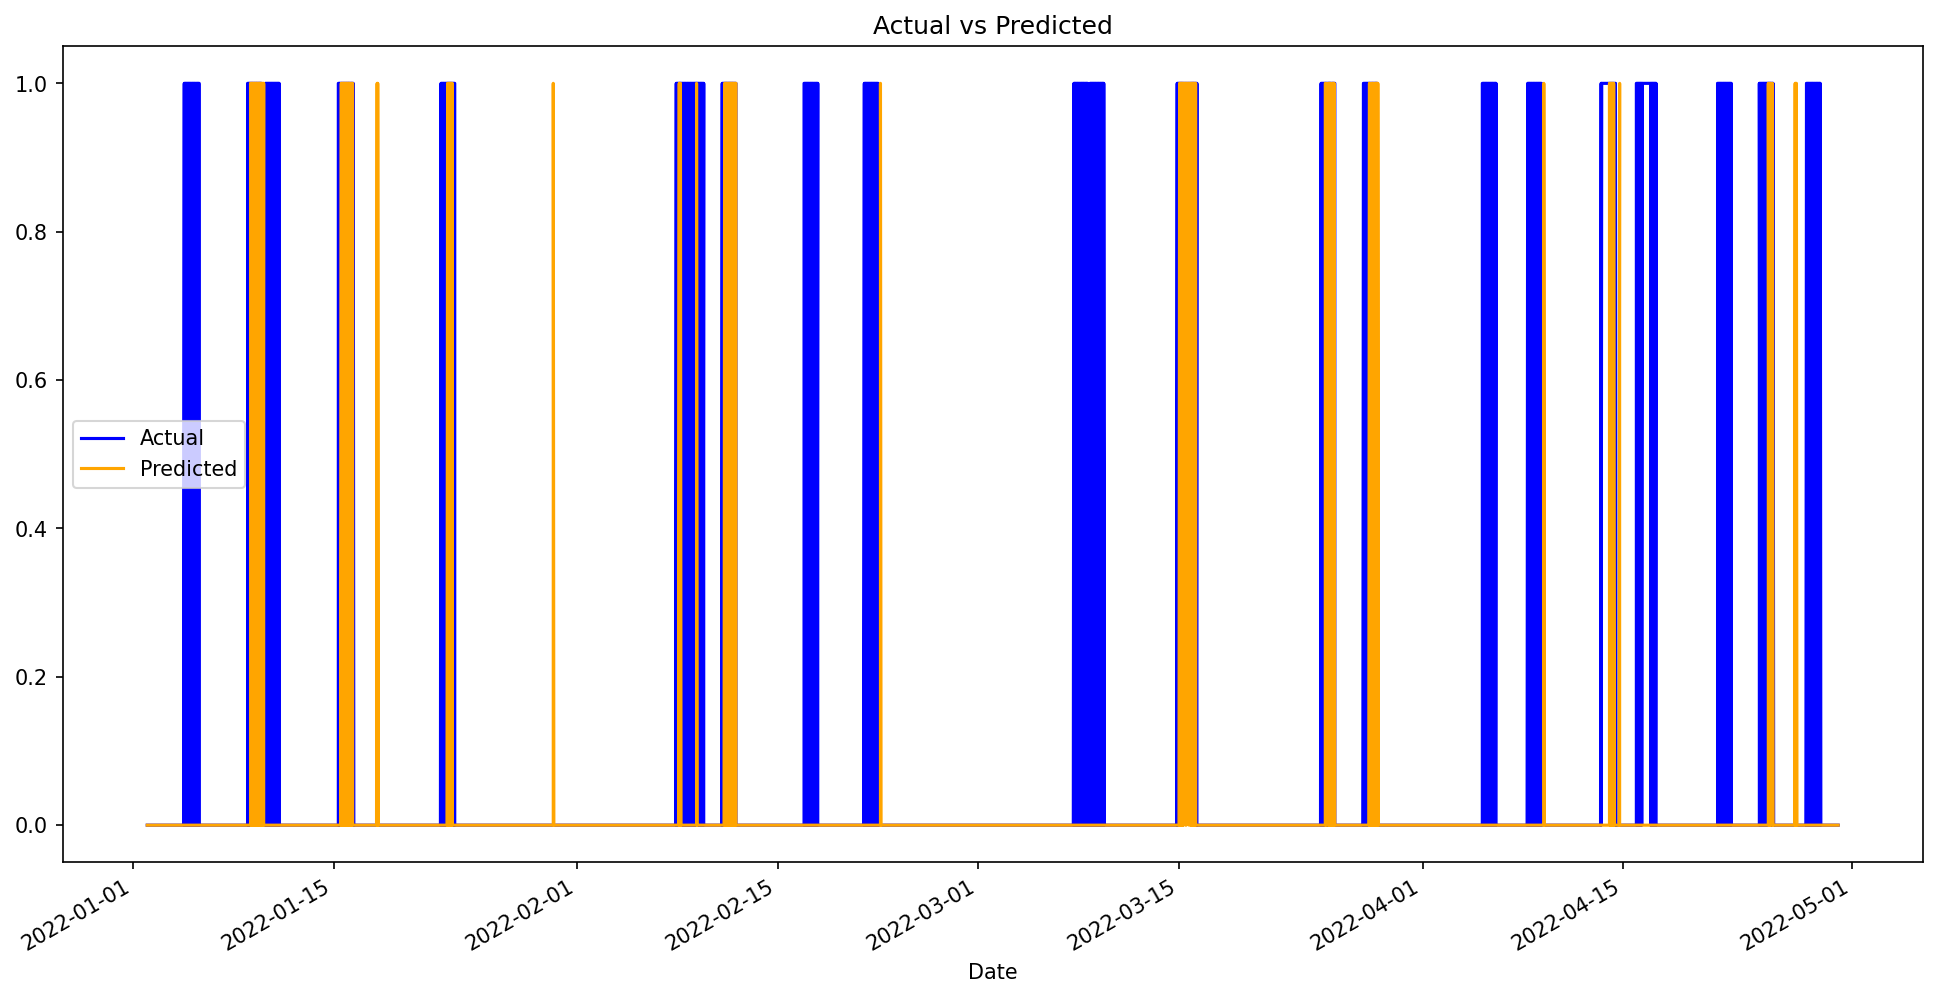

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8), dpi=150)

train_predictions_df['actual'].plot(label='Actual', color='blue')
train_predictions_df['0'].plot(label='Predicted', color='orange')

# adding title to the plot
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.legend()

## Advanced: Let's improve the model with Hyperparameter Optimization

We know there is a class imbalance that is leading to high precision, but very low recall.

LogisticRegression provides a class_weight hyperparameter to account for class imbalances, but what value should we set?

*Let's optimize hyperparameters to discover the best value*

Performing HPO requires appropriate hyperparameter space to search from. Some of the common hyperparameter spaces are:
- `Hp.ParamSpace.Categorical`
- `Hp.ParamSpace.IntegerRange`

Please refer to documentation of `Hp.ParamSpace` for more options.

For the following example, we will create spaces for 2 hyperparameters of our classifier pipe - mainly `class_weight` and `C`. We use `Hp.ParamSpace.Categorical` to specify the possible values the hyperparameter can take.

<div class="alert-info">
    <b>Exercise</b>: 

Add Hyperparameter Spaces to the LogisticRegression to find the best `class_weight` and `C` hyperparameters.
    <br>
    <div><i>Hint</i>: Pass a list such as `[0.05, 0.1, 0.9]` to `c3.Hp.ParamSpace.Categorical.fromValues()`
    </div>
    <br>
</div>

In [20]:
# TODO: Add a Hyperparameter space for the max_depth hyperparameter 
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

lr_param_spaces = {'class_weight': c3.Hp.ParamSpace.Categorical.fromValues(["None", "balanced"]), 
                   'C': c3.Hp.ParamSpace.Categorical.fromValues([0.05, 0.1, 0.9])}

In [21]:
clf_pipe = clf_pipe.withHyperparamSpaces(lr_param_spaces)

In [22]:
X_input, y_input = mla.var(), mla.var()
ss_out = ss_pipe(X_input)
y_output = clf_pipe(ss_out, y_input)
precision = precision_pipe(y_input, y_output)
recall = recall_pipe(y_input, y_output)
precision = precision_pipe(y_input, y_output)
pipeline = mla.pipeline(
    name='workshop-dag-hpo',
    x={'features': X_input},
    y={'failureLabel': y_input}, 
    out={'riskScore': y_output},
    scores={'precision':precision, 'recall':recall}
)

### Define the validation technique

In [23]:
my_optuna_search_algo = c3.Hpo.OptunaSearch(algorithm='Grid')

In [24]:
val_tech = c3.MlSplit.RandomHoldout(validationSize=0.25)

In [25]:
from datetime import datetime
experiment_name = f'WindTurbine_Hpo_{datetime.now()}'
hpo_spec = c3.Hpo.Spec(validationTechnique=val_tech,
                       algorithm=my_optuna_search_algo,
                       maxTrials=6,
                       maxConcurrentTrials=3,
                       hpoMetric='recall',
                       experimentName=experiment_name).withDefaults()

In [26]:
train_run = pipeline.train(
    x={'features': X_train}, 
    y={'failureLabel': y_train},
    hpoSpec=hpo_spec
)

/c3/platform/src/ml/pipe/pipeline/MlPipeline.py:525: UserWarning: Hpo.Experiment can be inspected by fetching Hpo.Experiment with command : c3.Hpo.Experiment(id='eb81c01d-570f-44e8-bd2f-65891996f8ff').get()
  warnings.warn("Hpo.Experiment can be inspected by fetching Hpo.Experiment with command : "


In [27]:
trained_pipeline = train_run.result()

In [28]:
my_hpo_experiment = trained_pipeline.hpoExperiment

In [29]:
all_trials_dt = my_hpo_experiment.trialSummary()
all_trials_dt

Trial Name  ...                                    Hyperparameters
5  WindTurbine_Hpo_2023-04-27 18:00:10.358892 -> ...  ...  {'LogisticRegression': {'C': 0.9, 'class_weigh...
0  WindTurbine_Hpo_2023-04-27 18:00:10.358892 -> ...  ...  {'LogisticRegression': {'C': 0.1, 'class_weigh...
2  WindTurbine_Hpo_2023-04-27 18:00:10.358892 -> ...  ...  {'LogisticRegression': {'C': 0.05, 'class_weig...
1  WindTurbine_Hpo_2023-04-27 18:00:10.358892 -> ...  ...  {'LogisticRegression': {'C': 0.1, 'class_weigh...
3  WindTurbine_Hpo_2023-04-27 18:00:10.358892 -> ...  ...  {'LogisticRegression': {'C': 0.9, 'class_weigh...
4  WindTurbine_Hpo_2023-04-27 18:00:10.358892 -> ...  ...  {'LogisticRegression': {'C': 0.05, 'class_weig...

[6 rows x 9 columns]

In [30]:
bestTrial = my_hpo_experiment.bestTrial()
print('Trial Name: ' + bestTrial.name)
print('Trial Status: ' + bestTrial.status)
print('Trial HP Combination Candidate:')
print(bestTrial.generatedParams.hyperparam)

Trial Name: WindTurbine_Hpo_2023-04-27 18:00:10.358892 -> Trial-5
Trial Status: succeeded
Trial HP Combination Candidate:
{LogisticRegression: {C: 0.9, class_weight: balanced}}


In [31]:
test_scores = trained_pipeline.score(
    x={'features': X_test}, 
    y={'failureLabel': y_test}
).result()

In [32]:
f1_score = 2*test_scores["recall"]*test_scores["precision"]/(test_scores["recall"]+test_scores["precision"])
print("F1 Score:", f1_score)
print("Recall:", test_scores["recall"])
print("Precision:", test_scores["precision"])

F1 Score: 0.28210526315789475
Recall: 0.5583333333333333
Precision: 0.18873239436619718


## Save the Pipeline

In [33]:
trained_pipeline.withId("turbine1-gearoiltemp-class-pipeline").upsert()

                     Name                   Type            Outputs                                                                   Connected to
0          y/failureLabel               <source>            ['out']      ['MlRecallMetric/x/x', 'LogisticRegression/y/y', 'MlPrecisionMetric/x/x']
1              x/features               <source>            ['out']                                                         ['StandardScaler/x/x']
0          MlRecallMetric         MlRecallMetric            ['out']                                                                  ['recall/in']
1      LogisticRegression            SklearnPipe            ['out']                ['riskScore/in', 'MlRecallMetric/y/y', 'MlPrecisionMetric/y/y']
2       MlPrecisionMetric      MlPrecisionMetric            ['out']                                                               ['precision/in']
3          StandardScaler            SklearnPipe            ['out']                                                   